In [8]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
# Configs
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    # Use LaTeX default serif font.
    "font.serif": [],
})
title_fontsize = 25
subtitle_fontsize = 23
axes_fontsize = 25
legend_fontsize = 20
tick_labels_fontsize = 20
annotations_fontsize = 20

base_path = 'measurements/Q4.1.a'
filenames = [os.path.join(base_path, file) for file in os.listdir(base_path) if (file.endswith('.txt') and not file.endswith('0.txt'))]
columns_to_keep = ['QPS', 'p95']

In [10]:
# Function to read data from .txt files and onrganize them in convenient dictionaries
def read_mcperf(filenames, columns_to_keep):
    data_dict = dict()
    for filename in filenames:
        try:
            parts = filename.split('-')
            thread = parts[1]
            core = parts[2]
            run = parts[3].split('.')[0]
            key = f'C{core}T{thread}'
            if key not in data_dict:
                data_dict[key] = {}
            df = pd.read_csv(filename, sep=r'\s+')
            df = df.loc[df['#type'] == 'read']
            df = df[columns_to_keep]
            df['p95'] = df['p95']/1000      #from microseconds to ms
            data_dict[key][f'run{run}'] = df
        except Exception as e:
            print(f"Error reading file {filename}: {e}")
    return data_dict


# Function to compute metrics for each CiTi (avg and std)
def compute_CiTi_metrics(data_dict):
    metrics_dict = dict()
    for CiTi, runs_data in data_dict.items():
        concatenated = pd.concat(runs_data.values(), axis=1)
        metrics_dict[CiTi] = pd.DataFrame({'avg_p95': concatenated['p95'].mean(axis=1), 
                                    'avg_QPS': concatenated['QPS'].mean(axis=1), 
                                    'std_p95': concatenated['p95'].std(axis=1), 
                                    'std_QPS': concatenated['QPS'].std(axis=1)})
    return metrics_dict

In [11]:
# Load data
data = read_mcperf(filenames, columns_to_keep)

# Get metrics to plot (avgs and stds)
metrics_dict = compute_CiTi_metrics(data)

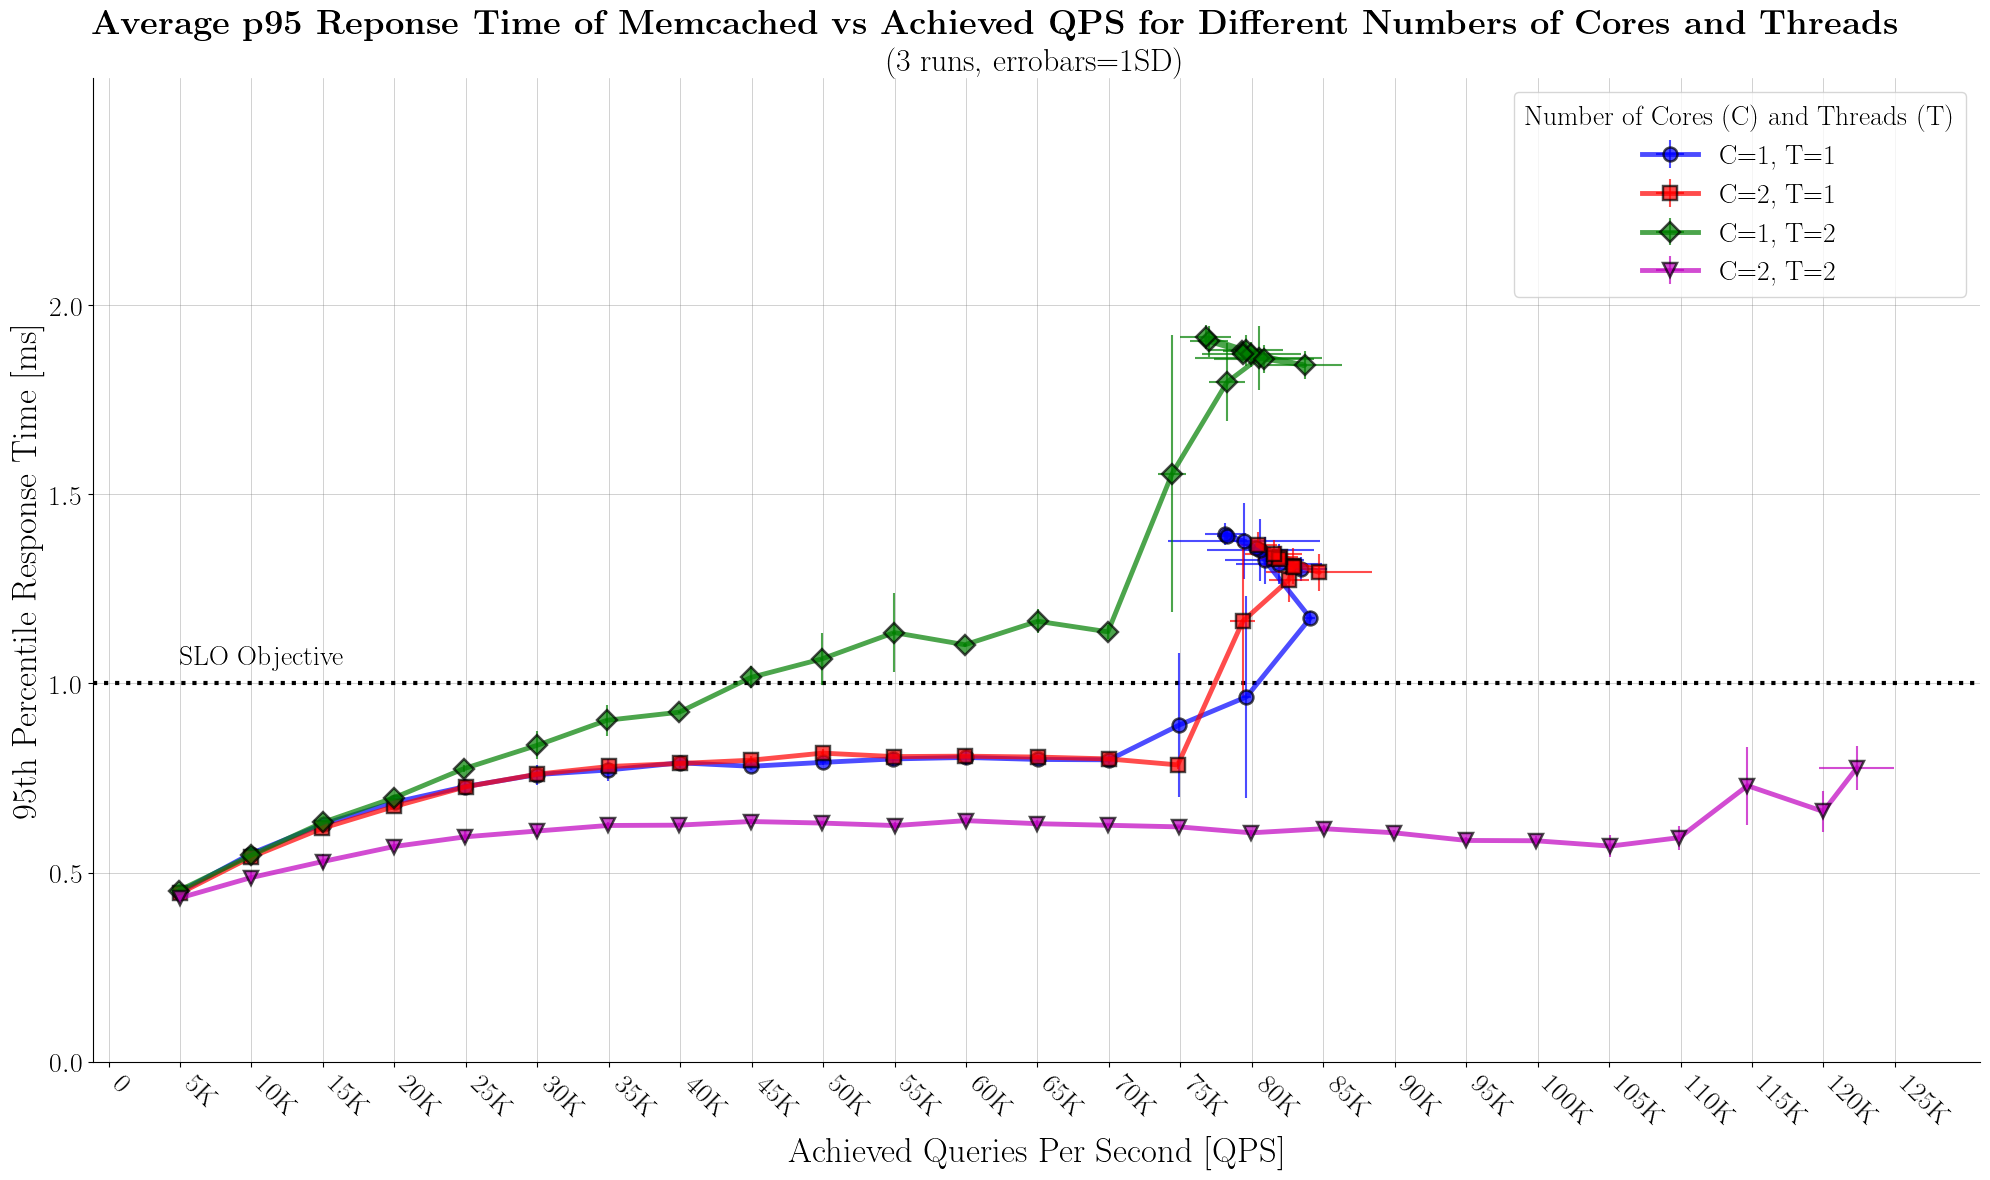

In [12]:
# Plot1a
fig, ax = plt.subplots(figsize=(20, 12))
markers = ['o', 's', 'D', 'v']
colors = [
    '#0000ff',  # blue
    '#ff0000',  # red
    '#007f00',  # green
    '#bf00bf',  # pink
    '#00bfbf',  # light blue
    '#bfbf00',  # ocra
    '#000000',  # black
]
legend_dict = {'C1T1' : 'C=1, T=1', 'C1T2' : 'C=1, T=2', 'C2T1' : 'C=2, T=1', 'C2T2' : 'C=2, T=2'}

slo_objective = ax.axhline(y=1, color='black', linestyle='dotted', linewidth=3)
ax.annotate('SLO Objective', xy=(5000, 1.05), color='black', fontsize=annotations_fontsize)
for i, (CiTi, metrics) in enumerate(metrics_dict.items()):
    ax.errorbar(metrics['avg_QPS'], metrics['avg_p95'], xerr=metrics['std_QPS'], yerr=metrics['std_p95'], marker=markers[i], 
                linewidth=3.5, alpha=0.7, markersize=10, elinewidth=1.5, color=colors[i], markeredgewidth=1.75, 
                markeredgecolor='black', label=legend_dict[CiTi])

# Style
x_labels = ['0', '5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', '45K', '50K', '55K', '60K',
            '65K', '70K', '75K', '80K', '85K', '90K', '95K', '100K', '105K', '110K', '115K', '120K', '125K']
ax.set_xticks(range(0, 126000, 5000), x_labels, rotation=-45, ha='left')
ax.set_xlabel('Achieved Queries Per Second [QPS]', fontsize=axes_fontsize)
ax.tick_params(axis='x', labelsize=tick_labels_fontsize)

y_labels = ['0', '0.5', '1', '1.5', '2', '2.5']
ax.set_ylim((0, 2.6))
ax.set_yticks( np.arange(0, 2.5, 0.5).tolist())
ax.set_ylabel('95th Percentile Response Time [ms]', fontsize=axes_fontsize)
ax.tick_params(axis='y', labelsize=tick_labels_fontsize) 

ax.legend(title='Number of Cores (C) and Threads (T)', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(color='grey', linewidth=0.5, alpha=0.5)
fig.suptitle(r'\bf{Average p95 Reponse Time of Memcached vs Achieved QPS for Different Numbers of Cores and Threads}', fontsize=title_fontsize)
ax.set_title('(3 runs, errobars=1SD)', fontsize=subtitle_fontsize)
fig.tight_layout()

#plt.show()
plt.savefig("plot4_1_a.pdf", bbox_inches = "tight")